# DSOSD: Robust loss-based dynamic seizure onset and spread detection

In [22]:
# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# OS imports
from os.path import join as ospj
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
plt.rcParams['image.cmap'] = 'magma'

In [23]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width

In [24]:
usr,passpath,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))
###########################
prodatapath = prodatapath # This is the path to where the pkl files i've sent
figpath = figpath         # This is the path to where you want saved figures to be stored

In [25]:
def wideform_preds(element,all_labels):
    return [label in element for label in all_labels]

def shortform_preds(element,all_labels):
    a = np.array(all_labels)[element]
    return a
def apply_dice_score(row):
    all_chs = row.all_chs
    for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
        row[col+'_chs'] = shortform_preds(row[col],all_chs)
        for pred in ['strict','loose']:
            ch_preds = row[f'{col[:3]}_chs_{pred}']
            if (len(ch_preds) + len(row[col+'_chs'])) == 0:
                row[f'{col}_{pred}_dice'] = 0
            else:
                row[f'{col}_{pred}_dice'] = dice_score(row[col+'_chs'],ch_preds)
    return row

def apply_kappa_score(row):
    all_chs = row.all_chs
    for col in ['ueo_chs_strict','ueo_chs_loose','sec_chs_strict','sec_chs_loose']:
        # need to turn model predictions into the wideform
        row[col+'_bool'] = wideform_preds(row[col],all_chs)
        for annot in ['consensus','any']:
            ch_preds = row[f'{col[:3]}_{annot}']
            # if (sum(ch_preds) + sum(row[col+'_bool'])) == 0:
            #     row[f'{col}_{annot}_kappa'] = 0
            # else:
            row[f'{col}_{annot}_kappa'] = cohen_kappa_score(row[col+'_bool'],ch_preds)
    return row

## Minimally supervised seizure detection

#### Loading and preparing data

In [26]:
anntype='consensus'
mdl_anntype = 'strict'
montage = 'bipolar'
mdl_preds = pd.read_pickle(ospj(prodatapath,f"pretrain_predicted_channels_wdice.pkl"))

In [27]:
mdl_preds_sorted = mdl_preds.sort_values(['Patient','approximate_onset','threshold','model'])

In [28]:
melt_cols = [f'ueo_{anntype}_{mdl_anntype}_dice',f'sec_{anntype}_{mdl_anntype}_dice']
keep_cols = [c for c in mdl_preds_sorted.columns if c not in melt_cols]
mdl_preds_long = mdl_preds_sorted.melt(id_vars=keep_cols,var_name='annot',value_name='dice')
mdl_preds_long.head()

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_any_chs,ueo_any_strict_dice,ueo_any_loose_dice,sec_consensus_chs,sec_consensus_loose_dice,sec_any_chs,sec_any_strict_dice,sec_any_loose_dice,annot,dice
0,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.225717,"[RA01, RB02, RB03, RC01, RC02, RC03]","[RA01, RA02, RB02, RB03, RB04, RC01, RC02, RC0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...",...,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.769231,0.750000,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.448980,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.488889,0.528302,ueo_consensus_strict_dice,0.833333
1,HUP224,HUP224_phaseII,WVNT,0.0,339143.6435,339143.6435,0.275237,"[LP02, LW01, RB01, RB03, RC01, RC03]","[LP02, LP03, LW01, LW02, RB01, RB02, RB03, RB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.615385,0.736842,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.272727,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.373333,0.347826,ueo_consensus_strict_dice,0.666667
2,HUP224,HUP224_phaseII,LSTM,0.0,339143.6435,339143.6435,3.053656,"[LB03, RB02, RB03, RC01]","[LB03, LB04, RB02, RB03, RB04, RC01, RC02]","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...",...,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.545455,0.714286,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.468085,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.511628,0.509804,ueo_consensus_strict_dice,0.600000
3,HUP224,HUP224_phaseII,NRG,0.0,339143.6435,339143.6435,130.942159,[],[],[],...,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.000000,0.000000,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.000000,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.000000,0.000000,ueo_consensus_strict_dice,0.000000
4,HUP224,HUP224_phaseII,AbsSlp,0.0,491467.8046,491467.8046,0.207939,"[RA01, RA03, RA04, RA05, RB01, RB02, RB03, RB0...","[RA01, RA02, RA03, RA04, RA05, RA06, RB01, RB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...",...,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.600000,0.538462,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.369231,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.509091,0.463768,ueo_consensus_strict_dice,0.631579


#### Plotting optimal threshold performance

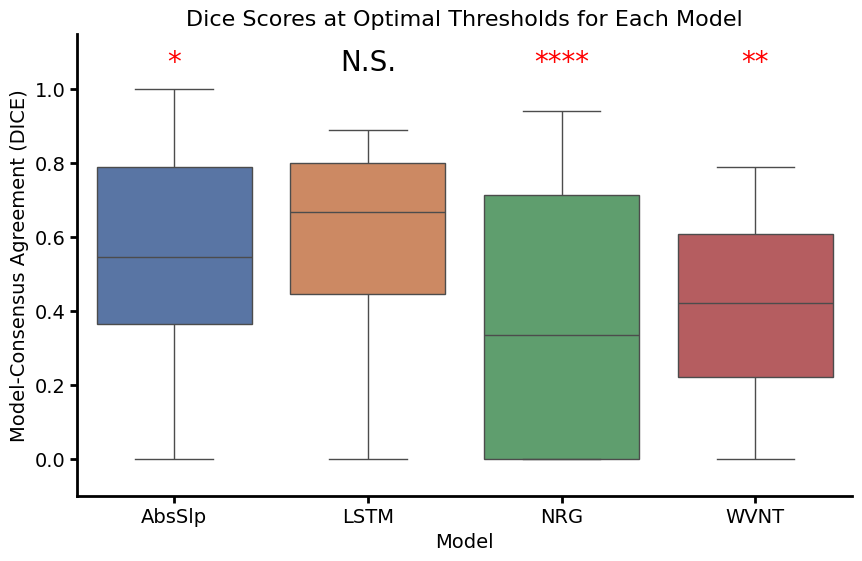

In [29]:
optimal_thresholds = mdl_preds_long.loc[mdl_preds_long.groupby(['Patient', 'approximate_onset','model'])['dice'].idxmax()][["model","dice","Patient","stim","approximate_onset"]]
# Step 2: Create a box plot of dice scores at optimal thresholds for each model
plt.figure(figsize=(10, 6))
sns.boxplot(data=optimal_thresholds, x='model', y='dice',palette='deep')
plt.title('Dice Scores at Optimal Thresholds for Each Model')
plt.xlabel('Model')
plt.ylabel('Model-Consensus Agreement (DICE)')
sns.despine()
sigs = ['*','N.S.','****','**']
cols = ["red","black","red","red"]
for i in range(4):
    plt.text(i,1.05,sigs[i],fontsize=20,color=cols[i],ha='center')
plt.ylim([-.1,1.15])
plt.show()



In [30]:
optimal_thresholds.isna()

,model,dice,Patient,stim,approximate_onset
0,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
1,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
288,False,False,False,False,False
292,False,False,False,False,False
295,False,False,False,False,False
294,False,False,False,False,False


#### Comparing to clinician consensus

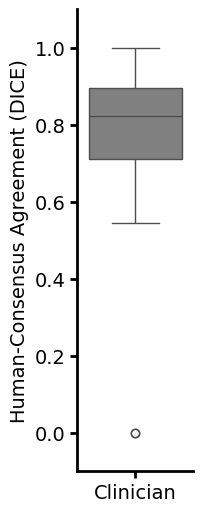

In [31]:
consensus_annots = pd.read_pickle(ospj(prodatapath,'stim_seizure_information_consensus.pkl'))
for i_r, row in consensus_annots.iterrows():
    annot_sets = row.ueo
    die = 0
    for annot in annot_sets:
        die += f1_score(annot,row.ueo_consensus)
    consensus_annots.loc[i_r,'f1'] = die/len(annot_sets)
plt.figure(figsize=(1.5,6))
plt.tight_layout()
sns.boxplot(consensus_annots,y='f1',color='grey')
plt.xticks([0],['Clinician'])
plt.ylabel('Human-Consensus Agreement (DICE)')
plt.ylim([-.1,1.1])
sns.despine()

In [32]:
for mdl in optimal_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(consensus_annots.f1,optimal_thresholds[optimal_thresholds.model == mdl].dice))

AbsSlp
MannwhitneyuResult(statistic=2054.0, pvalue=1.6523160925772603e-06)
LSTM
MannwhitneyuResult(statistic=2012.0, pvalue=6.188724295809462e-06)
NRG
MannwhitneyuResult(statistic=2174.5, pvalue=2.4226358691675646e-08)
WVNT
MannwhitneyuResult(statistic=2398.0, pvalue=2.2328332068483136e-12)


#### Combining model and clinician annotations

In [12]:
consensus_annots["model"] = ["Clin."]*len(consensus_annots)
consensus_annots["dice"] = consensus_annots["f1"]
optimal_thresholds['patient'] = optimal_thresholds['Patient']
optimal_thresholds.drop('Patient',axis=1,inplace=True)
all_plot_agreements = pd.concat([optimal_thresholds,consensus_annots[["patient","stim","approximate_onset","model","dice"]]])

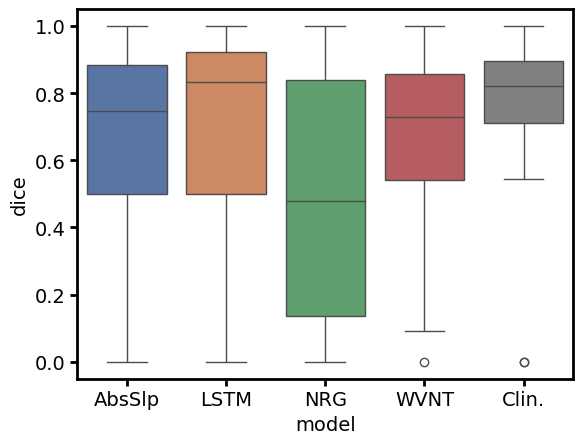

In [13]:
colors = sns.color_palette("deep", 4)
ax = sns.boxplot(all_plot_agreements,x='model',y='dice',palette = np.vstack([np.array(colors),[.5,.5,.5]]))

## Customizing plots

#### No Chop

In [33]:
all_plot_agreements_nochop = all_plot_agreements[all_plot_agreements.patient.apply(lambda x: 'HUP' in x)]

Stats comparing models to clinician
AbsSlp
MannwhitneyuResult(statistic=1562.5, pvalue=0.17197218206543363)
LSTM
MannwhitneyuResult(statistic=1304.0, pvalue=0.7571404595781034)
NRG
MannwhitneyuResult(statistic=1845.0, pvalue=0.001342567053537083)
WVNT
MannwhitneyuResult(statistic=1683.0, pvalue=0.03159414807331248)


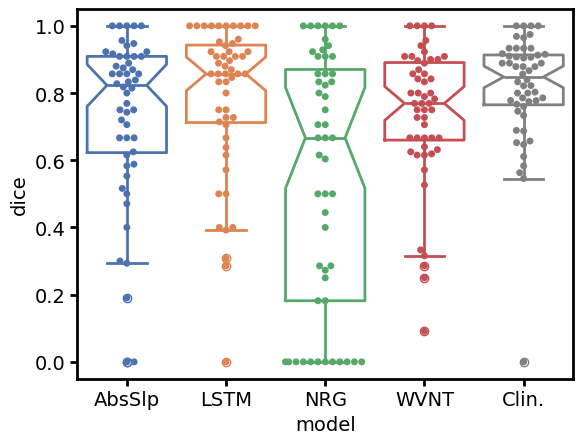

In [34]:
colors = sns.color_palette("deep", 4)
ax = sns.boxplot(all_plot_agreements_nochop,x='model',y='dice',palette = np.vstack([np.array(colors),[.5,.5,.5]]),fill=False,notch=True)
sns.swarmplot(all_plot_agreements_nochop,x='model',y='dice',palette = np.vstack([np.array(colors),[.5,.5,.5]]))
stat_dat = all_plot_agreements_nochop
print("Stats comparing models to clinician")
for mdl in optimal_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(stat_dat[stat_dat.model == 'Clin.'].dice,stat_dat[stat_dat.model == mdl].dice))

#### No stim

Stats comparing models to clinicians
AbsSlp
MannwhitneyuResult(statistic=748.5, pvalue=0.4921305843520749)
LSTM
MannwhitneyuResult(statistic=670.0, pvalue=0.8795195945439538)
NRG
MannwhitneyuResult(statistic=840.5, pvalue=0.09225393025892936)
WVNT
MannwhitneyuResult(statistic=860.0, pvalue=0.05834113195081058)


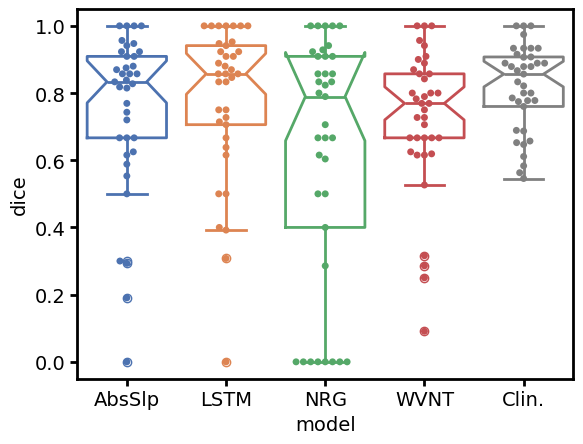

In [16]:
all_plot_agreements_nostim = all_plot_agreements_nochop[all_plot_agreements_nochop.stim == 0]
colors = sns.color_palette("deep", 4)
ax = sns.boxplot(all_plot_agreements_nostim,x='model',y='dice',palette = np.vstack([np.array(colors),[.5,.5,.5]]),notch=True,fill=False)
sns.swarmplot(all_plot_agreements_nostim,x='model',y='dice',palette = np.vstack([np.array(colors),[.5,.5,.5]]))
stat_dat = all_plot_agreements_nostim
print("Stats comparing models to clinicians")
for mdl in optimal_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(stat_dat[stat_dat.model == 'Clin.'].dice,stat_dat[stat_dat.model == mdl].dice))

#### Only Stim

Stats comparing models to clinicians
AbsSlp
MannwhitneyuResult(statistic=748.5, pvalue=0.4921305843520749)
LSTM
MannwhitneyuResult(statistic=670.0, pvalue=0.8795195945439538)
NRG
MannwhitneyuResult(statistic=840.5, pvalue=0.09225393025892936)
WVNT
MannwhitneyuResult(statistic=860.0, pvalue=0.05834113195081058)


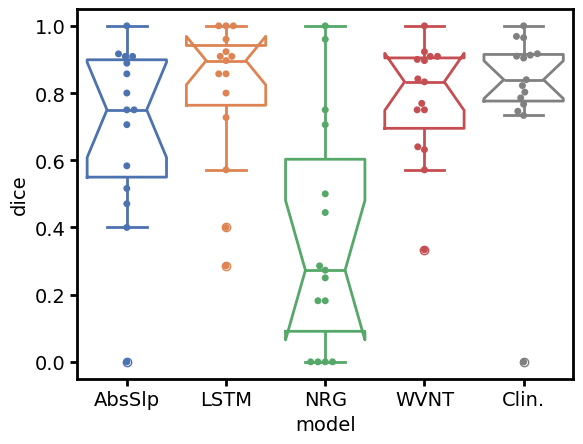

In [17]:
all_plot_agreements_stim = all_plot_agreements_nochop[all_plot_agreements_nochop.stim == 1]
colors = sns.color_palette("deep", 4)
ax = sns.boxplot(all_plot_agreements_stim,x='model',y='dice',palette = np.vstack([np.array(colors),[.5,.5,.5]]),notch=True,fill=False)
sns.swarmplot(all_plot_agreements_stim,x='model',y='dice',palette = np.vstack([np.array(colors),[.5,.5,.5]]))
stat_dat = all_plot_agreements_nostim
print("Stats comparing models to clinicians")
for mdl in optimal_thresholds.model.unique():
    print(mdl)
    print(sc.stats.mannwhitneyu(stat_dat[stat_dat.model == 'Clin.'].dice,stat_dat[stat_dat.model == mdl].dice))

## KDE Model Predictions

#### Loading unsupervised detections

In [18]:
# Loading in human annotations with consensus annotation already created
annotations_df = pd.read_pickle(ospj(prodatapath,"stim_seizure_information_consensus.pkl"))
annotations_df.columns = ['Patient' if c == 'patient' else c for c in annotations_df.columns]

# Loading in predicted channels for all models from generate_model_annotations.py
predicted_channels = pd.read_pickle(ospj(prodatapath,"kde_predicted_channels.pkl"))
predicted_channels = predicted_channels[predicted_channels.to_annotate == 1]

# Sorting
predicted_channels.sort_values('approximate_onset',inplace=True)
predicted_channels = predicted_channels[predicted_channels.stim == 0]
annotations_df.sort_values('approximate_onset',inplace=True)

# Creating a merged table with human and machine annotations based on approximate seizure onset time
pred_channels_wannots = pd.merge_asof(predicted_channels,
                                    annotations_df[['approximate_onset','Patient','all_chs','ueo_consensus','ueo_any','sec_consensus','sec_any']],
                                    on='approximate_onset',by='Patient',
                                    tolerance = 240,
                                    direction='nearest')
pred_channels_wannots.dropna(axis=0,subset='ueo_consensus',inplace=True)
pred_channels_wannots.sort_values(['Patient','iEEG_ID','approximate_onset'],inplace=True)
pred_channels_wdice = pred_channels_wannots.apply(apply_dice_score,axis=1)
pred_channels_wkappa = pred_channels_wannots.apply(apply_kappa_score,axis=1)

In [19]:
pred_channels_wdice.head()

,Patient,iEEG_ID,model,stim,approximate_onset,ueo_time_consensus,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_consensus_loose_dice,ueo_any_chs,ueo_any_strict_dice,ueo_any_loose_dice,sec_consensus_chs,sec_consensus_strict_dice,sec_consensus_loose_dice,sec_any_chs,sec_any_strict_dice,sec_any_loose_dice
76,HUP224,HUP224_phaseII,WVNT,0.0,339143.6435,339143.6435,0.275237,"[LP02, LW01, RB01, RB03, RC01, RC03]","[LP02, LP03, LW01, LW02, RB01, RB02, RB03, RB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",...,0.666667,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.615385,0.736842,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.309859,0.272727,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.373333,0.347826
77,HUP224,HUP224_phaseII,NRG,0.0,339143.6435,339143.6435,130.942159,[],[],[],...,0.000000,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.000000,0.000000,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.000000,0.000000,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.000000,0.000000
78,HUP224,HUP224_phaseII,AbsSlp,0.0,339143.6435,339143.6435,0.225717,"[RA01, RB02, RB03, RC01, RC02, RC03]","[RA01, RA02, RB02, RB03, RB04, RC01, RC02, RC0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...",...,0.666667,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.769231,0.750000,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.487805,0.448980,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.488889,0.528302
79,HUP224,HUP224_phaseII,LSTM,0.0,339143.6435,339143.6435,3.053656,"[LB03, RB02, RB03, RC01]","[LB03, LB04, RB02, RB03, RB04, RC01, RC02]","[LA01, LA02, LA03, LA04, LA05, LB01, LB02, LB0...",...,0.615385,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.545455,0.714286,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.512821,0.468085,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.511628,0.509804
128,HUP224,HUP224_phaseII,LSTM,0.0,491467.8046,491467.8046,2.260310,"[LA01, LB01, LB02, LB03, LB05, LC01, LC03, RA0...","[LA01, LA02, LB01, LB02, LB03, LB04, LB05, LB0...","[LA01, LA02, LA03, LA04, LA05, LA06, LB01, LB0...",...,0.375000,"[RB01, RB02, RB03, RB04, RC01, RC02, RC03]",0.500000,0.424242,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.468085,0.413793,"[LB01, LB02, LB03, LB04, LC01, LC02, RB01, RB0...",0.549020,0.516129


Text(31.763888888888886, 0.5, 'Agreement (DICE)')

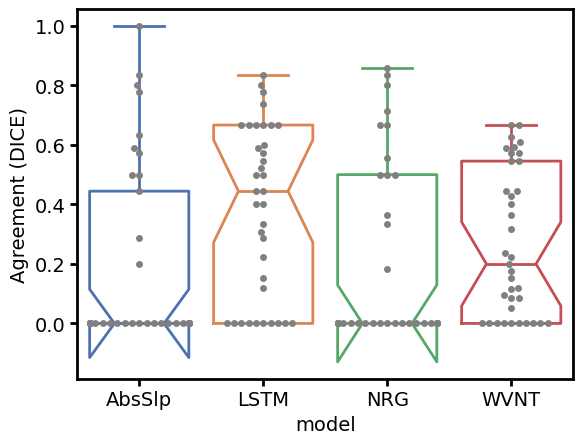

In [21]:
sns.boxplot(pred_channels_wdice,x='model',y='ueo_consensus_strict_dice',palette='deep',order=['AbsSlp','LSTM','NRG','WVNT'],notch=True,fill=False)
sns.swarmplot(pred_channels_wdice,x='model',y='ueo_consensus_strict_dice',color='gray')
plt.ylabel("Agreement (DICE)")